In [101]:
# CAM visualization: 2d grid of scores associated with an output class, computed for every location in any input image, telling how important each location is for the class under consideration, saying which part of a image led the convnet to take its final decision

In [127]:
from keras.models import load_model
from keras.utils import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
import numpy as np
from keras import backend as K
import cv2
import matplotlib.pyplot as plt
import os

In [128]:
# customized metrics

def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [129]:
# load model used for visualization
model = load_model(os.path.join("..","models","CNN_dropout_batch_bigger_class_weights.h5"),custom_objects = {"precision": precision, "recall": recall})

2023-01-05 15:19:13.600377: W tensorflow/c/c_api.cc:291] Operation '{name:'block4_conv3/bias/Assign' id:8580 op device:{requested: '', assigned: ''} def:{{{node block4_conv3/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](block4_conv3/bias, block4_conv3/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-01-05 15:19:25.857371: W tensorflow/c/c_api.cc:291] Operation '{name:'momentum_7/Assign' id:9082 op device:{requested: '', assigned: ''} def:{{{node momentum_7/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](momentum_7, momentum_7/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error

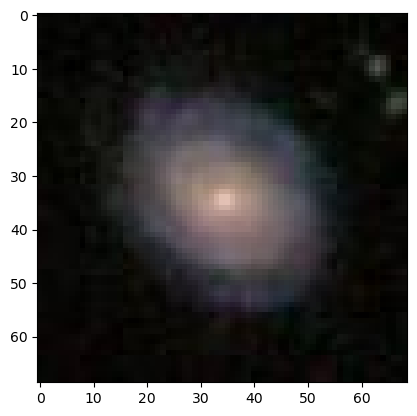

In [130]:
# choose image to run visualization on
img_path = os.path.join("..","workspace","images","all","6983.jpg")

img = load_img(img_path, target_size=(69, 69))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
plt.imshow(img)
plt.show()

In [131]:
# one-hot encoding vector with the class predicted
preds = model.predict(x)
print(preds)
np.argmax(preds[0]) # entry maximally activated

/Users/francoterranova/lib/python3.9/site-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-01-05 15:19:35.735421: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_1_7/Softmax' id:8780 op device:{requested: '', assigned: ''} def:{{{node dense_1_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_1_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


[[0. 1. 0. 0. 0. 0. 0. 0. 0.]]


In [134]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dense_1 (Dense)             (None, 9)                 585       
                                                                 
Total params: 14,846,409
Trainable params: 7,211,145
Non-trainable params: 7,635,264
_________________________________________________________________


In [135]:
output = model.output[:, np.argmax(preds[0])]

# last convolutional layer in the architecture
last_conv_layer = model.get_layer('conv2d_3')

Tensor("strided_slice_22:0", shape=(None,), dtype=float32)


In [136]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

# weight every channel of the output feature map by the gradient of the maximally activated class with respect to the channel
grads = K.gradients(output, last_conv_layer.output)[0]

# vector where each entry is the mean intensity of the gradient over a specific feature-map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input],
                     [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

# multiply each channel depending on how important it is wrt to the target class
for i in range(64):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# channel-wise mean of the resulting feature map in the heatmap of the class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

AttributeError: 'NoneType' object has no attribute 'dtype'

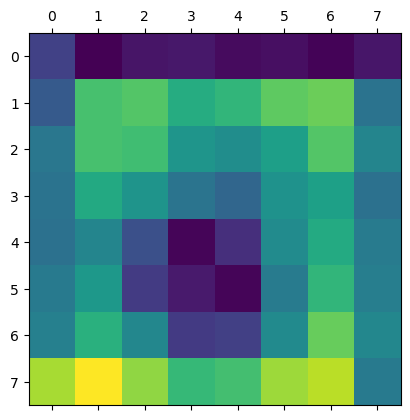

In [122]:
# normalize the heatmap between 0 and 1 for visualization purposes
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [126]:
# superimpose the original image
heatmap_intensity_factor = 0.2
img = cv2.imread(img_path)

# resize the heatmap to be the same size of the image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)

# write superimposed image to file
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * heatmap_intensity_factor + img
cv2.imwrite('result.jpg', superimposed_img)

True